# Env Setting

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
# Run in Colab to check the files in drive

# %cd /content/drive/MyDrive/Maglearn_2/MagNet_comb
# !ls

In [18]:
import os
from path_config import *

model_saved_name = os.path.join(material_name, "model_colab.ckpt")

In [19]:
# current_path = os.getcwd()
# index = current_path.find("DeepLearning")
# current_path = current_path[index:]
# current_path='/content/drive/MyDrive/'+current_path
# current_path=current_path.replace('\\','/')
# "colab_dir = "+current_path
# current_path

## Colab

In [20]:
current_path = os.getcwd()
colab_dir = current_path
print(f'{colab_dir}')

platform = 'auto' # auto detect platform (colab, windows_local, linux_local, unknown)
#platform = 'colab'
#platform = 'windows_local'
#platform = 'linux_local'
#platform = 'unknown'

/content/drive/MyDrive/Maglearn_2/MagNet_comb


### Path config

In [21]:
import os

try:
    from google.colab import drive
    drive.mount("/content/drive")
except ImportError:
    if os.path.exists('c:/'):  # check if it is windows
        platform = 'windows_local'
    elif os.path.exists('/home/'):  # check if it is linux
        platform = 'linux_local'
    else:
        platform = 'unknown'
else:
    platform = 'colab'

if platform == 'colab':
  os.chdir(colab_dir)

print('\ncurrent execution path: ', os.getcwd())  #获取当前工作目录路径
print('\ncurrent platform: ', platform)  #获取当前工作目录路径

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

current execution path:  /content/drive/MyDrive/Maglearn_2/MagNet_comb

current platform:  colab


# Cuda check

In [22]:
import torch

gpu_num = 0
cuda_ready = False

if torch.cuda.is_available():
    cuda_ready = True
    print('cuda good!')
    gpu_num = torch.cuda.device_count()
    if (gpu_num < 1):
        print('GPU unavailable')
    else:
        print('GPU num: ', gpu_num)  # 查看GPU数量
        for gpu in range(gpu_num):
            print('GPU type: ', torch.cuda.get_device_name(gpu))  # 查看GPU名称
            print('GPU memory: {:.2f} Gbyte'.format(
                torch.cuda.get_device_properties(gpu).total_memory /
                1e9))  # 查看GPU总内存
else:
    cuda_ready = False
    print('cuda unavailable!')


cuda good!
GPU num:  1
GPU type:  Tesla T4
GPU memory: 15.83 Gbyte


# Start coding

In [23]:
print(platform)
print(os.getcwd())
print(cuda_ready)
print(os.path.abspath(''))

colab
/content/drive/MyDrive/Maglearn_2/MagNet_comb
True
/content/drive/MyDrive/Maglearn_2/MagNet_comb


In [24]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


import NW_LSTM
import NN_DataLoader

In [25]:
# Check if CUDA is available and if so, set the device to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print("Device using ",device)

# Instantiate the model with appropriate dimensions
model = model = NW_LSTM.get_global_model().to(device)

# Print the model architecture and parameters number
print(model)
print("Total number of parameters: ", sum(p.numel() for p in model.parameters()))

# Load the pre-train model if it exists
try:
    model.load_state_dict(torch.load(model_saved_name))
    print("Pre-train model loaded")
except:
    print("No model found, start training from scratch")
    pass

# Define the loss function and optimizer
lr = 1e-3 # Define learning rate

#loss_fn = nn.MSELoss()
loss_fn = NW_LSTM.RelativeLoss()
#loss_fn = NW_LSTM.RelativeLoss_abs()
optimizer = optim.AdamW(model.parameters(), lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=0, last_epoch=-1)

Device using  cuda
LSTMSeq2One(
  (lstm): LSTM(1, 30, num_layers=3, batch_first=True)
  (fc1): Linear(in_features=32, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=196, bias=True)
  (fc3): Linear(in_features=196, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=96, bias=True)
  (fc5): Linear(in_features=96, out_features=32, bias=True)
  (fc6): Linear(in_features=32, out_features=32, bias=True)
  (fc7): Linear(in_features=32, out_features=16, bias=True)
  (fc8): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
  (leaky_relu): LeakyReLU(negative_slope=0.01)
  (elu): ELU(alpha=1.0)
  (sigmoid): Sigmoid()
)
Total number of parameters:  90653
Pre-train model loaded


In [26]:
# Default para in desktop env
epochs = 100
valid_batch_size=1000

if platform == "colab":
  epochs = 500
  valid_batch_size=3000

# Define dataset path and model name
dataset_path = os.path.join(material_name, savePathstd)
model_saved_name = os.path.join(material_name, "model_colab.ckpt")


# print(os.path.normpath(material_name + dataset_path + "/train.mat"))

train_dataloader = NN_DataLoader.get_dataLoader(os.path.normpath(dataset_path +
                                                            "/train.mat"),
                                          batch_size=128)


# Get validation data
valid_dataloader = NN_DataLoader.get_dataLoader(os.path.normpath(dataset_path +
                                                            "/valid.mat"),
                                            batch_size=valid_batch_size)
valid_inputs, valid_targets = next(iter(valid_dataloader))
valid_inputs, valid_targets = valid_inputs.to(device), valid_targets.to(device)


# Prepare a list to store validation relative losses per epoch
val_relative_losses = []

# estimate time used for training
import time
t0 = time.perf_counter()

# Save the model with the lowest validation loss
with torch.no_grad():
    valid_outputs = model(valid_inputs)
    # Compute loss
    minium_loss = loss_fn(valid_outputs, valid_targets)
    relative_loss = torch.mean(torch.abs((valid_outputs - valid_targets) / valid_targets)) * 100
    val_relative_losses.append(relative_loss.item())

# Train the model
for epoch in range(epochs):

    # estimate time used for one epoch(s)
    t_epoch = time.perf_counter() - t0
    t0 = time.perf_counter()

    # Train one epoch
    for i, (train_inputs, train_targets) in enumerate(train_dataloader):
        # Move data to device
        train_inputs, train_targets = train_inputs.to(device), train_targets.to(device)

        # Forward pass
        train_outputs = model(train_inputs)

        # Compute loss
        loss = loss_fn(train_outputs, train_targets)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Compute validation loss
    if epoch > 0:
        with torch.no_grad():
            valid_outputs = model(valid_inputs)
            # Compute loss
            valid_loss = loss_fn(valid_outputs, valid_targets)
            relative_loss = torch.mean(torch.abs((valid_outputs - valid_targets) / valid_targets)) * 100
            val_relative_losses.append(relative_loss.item())

        # 只要有提升就保存模型
        if valid_loss < minium_loss:
            minium_loss = valid_loss
            torch.save(model.state_dict(), model_saved_name)
            print(f"  Model saved , Validation Loss: {valid_loss.item():.3e}, lr: {optimizer.param_groups[0]['lr']:.3e}")

    # update lr
    scheduler.step()

    # Print loss every 10 epochs 每十次会打印Epoch
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {loss.item():.3e}, "
            #   f"Validation Loss: {valid_loss.item():.3e} ,"
              f"Remain time: {t_epoch/60 * (epochs - epoch - 1):.1f} min")



Epoch 10/500, Training Loss: 3.978e-04, Remain time: 19.2 min
Epoch 20/500, Training Loss: 8.378e-04, Remain time: 18.8 min
Epoch 30/500, Training Loss: 9.632e-03, Remain time: 18.3 min
Epoch 40/500, Training Loss: 1.512e-03, Remain time: 19.5 min
Epoch 50/500, Training Loss: 6.501e-04, Remain time: 20.2 min
Epoch 60/500, Training Loss: 5.406e-04, Remain time: 21.5 min
Epoch 70/500, Training Loss: 1.151e-03, Remain time: 22.3 min
Epoch 80/500, Training Loss: 7.656e-04, Remain time: 23.0 min
Epoch 90/500, Training Loss: 4.592e-04, Remain time: 21.9 min
Epoch 100/500, Training Loss: 3.820e-04, Remain time: 20.6 min
Epoch 110/500, Training Loss: 5.689e-04, Remain time: 21.1 min
Epoch 120/500, Training Loss: 2.810e-04, Remain time: 20.3 min
Epoch 130/500, Training Loss: 3.648e-04, Remain time: 20.8 min
Epoch 140/500, Training Loss: 5.711e-04, Remain time: 20.9 min
Epoch 150/500, Training Loss: 4.849e-04, Remain time: 18.4 min
Epoch 160/500, Training Loss: 6.000e-04, Remain time: 16.4 min
E

# Converge Plot

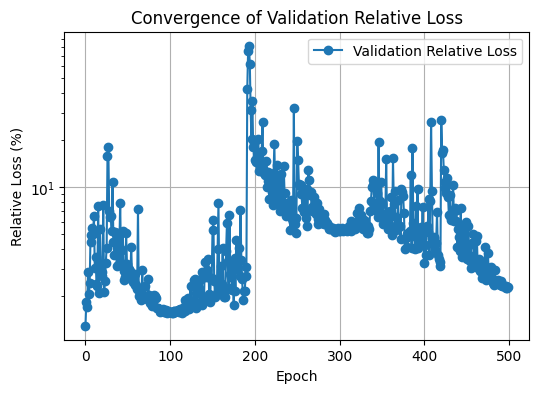

In [27]:
# Plot the validation relative loss vs epochs
plt.figure(figsize=(6,4))
plt.plot(range(len(val_relative_losses)), val_relative_losses, marker='o', label='Validation Relative Loss')
plt.xlabel('Epoch')
plt.ylabel('Relative Loss (%)')
plt.title('Convergence of Validation Relative Loss')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()


## GPU monitor
### nvidia-smi -l 3